<a href="https://colab.research.google.com/github/tocom242242/aifx_blog_codes/blob/master/nn_tf2/conv/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
import copy
from IPython import display

In [2]:
def plot_imgs(imgs,shuffle=False):
    plt.figure(figsize=(10,10))
    plot_imgs = copy.deepcopy(imgs)
    if shuffle:
        np.random.shuffle(plot_imgs)
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(imgs[i]), cmap="gray", vmin=0, vmax=1)
    plt.show()

In [3]:
# (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
# (x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [4]:
x_train = x_train / 255
x_test = x_test / 255

In [5]:
def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image

In [6]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")



In [7]:
x_train.shape[1:]

(32, 32, 3)

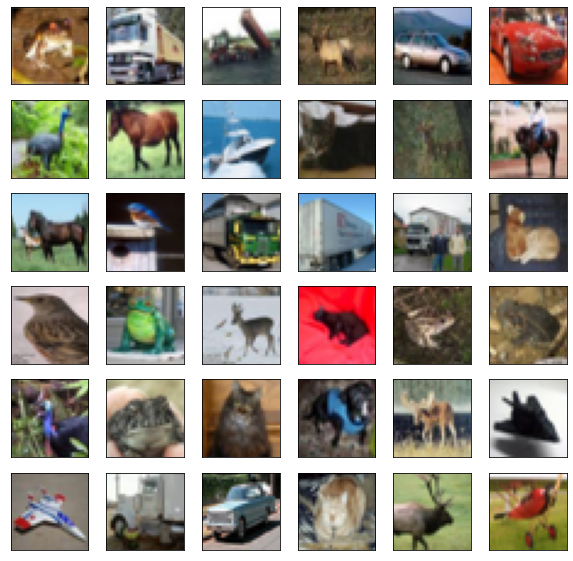

In [8]:
plot_imgs(x_train)

In [9]:
def downsample(filters, size, apply_batchnorm=True, strides=2):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  result.add(tf.keras.layers.LeakyReLU())
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())


  return result

In [10]:
def upsample(filters, size, apply_batchnorm=True, strides=2):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.ReLU())
  result.add(tf.keras.layers.BatchNormalization())

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  return result

In [11]:
input_shape = x_train.shape[1:]
output_channel = x_train.shape[-1]
size = 3 # カーネルサイズ

inputs = tf.keras.layers.Input(shape=input_shape)

def build_model():
  inputs = tf.keras.layers.Input(shape=input_shape)

  down1 = downsample(32, size, strides=1,apply_batchnorm=False)(inputs)
  down2 = downsample(64, size,strides=2,apply_batchnorm=True)(down1)
  down3 = downsample(128, size,strides=1,apply_batchnorm=False)(down2)

  up1 =upsample(64, size,  strides=1,apply_batchnorm=True)(down3)
  con1 = tf.keras.layers.Concatenate()([up1, down2])
  up2 = upsample(32, size, strides=2,apply_batchnorm=False)(con1)
  con1 = tf.keras.layers.Concatenate()([up2, down1])

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, size,
                                         strides=1,
                                         padding='same',
                                         kernel_initializer=initializer,
                                        #  activation='tanh')  # (batch_size, 256, 256, 3)
                                         activation='sigmoid')  # (batch_size, 256, 256, 3)

  x = last(con1)
  return tf.keras.Model(inputs=inputs, outputs=x)

model = build_model()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 16, 16, 64)   18688       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 16, 16, 128)  73728       sequential_1[0][0]               
______________________________________________________________________________________________

In [12]:
n = 10
input_num = 100
def plot_rec(input_images):
    plt.figure(figsize=(20, 4))
    decoded_imgs = model(input_images[:input_num], training=True)
    plt_index = np.random.randint(0,input_num,size=n)
    decoded_imgs = tf.squeeze(decoded_imgs)
    input_images = np.squeeze(input_images)

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        idx = plt_index[i]
        plt.imshow(input_images[idx], cmap="gray", vmin=0, vmax=1)
        plt.title("input")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[idx], cmap="gray", vmin=0, vmax=1)
        plt.title("output")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [13]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            display.clear_output(wait=True)
            plot_rec(x_train)

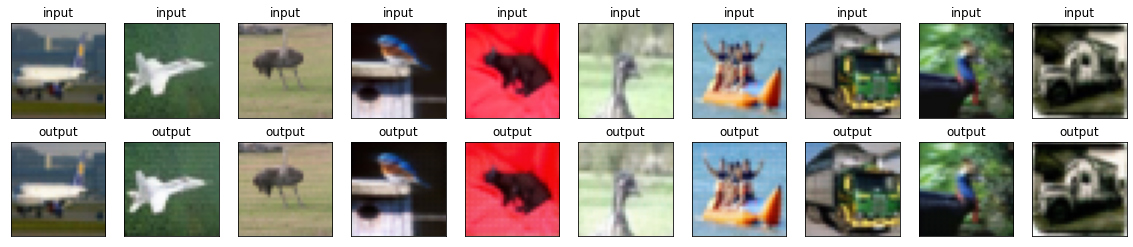

Epoch 42/50
417/417 [==============================] - 4s 10ms/step - loss: 0.5473 - val_loss: 0.5484
Epoch 43/50
417/417 [==============================] - 4s 10ms/step - loss: 0.5472 - val_loss: 0.5483
Epoch 44/50
417/417 [==============================] - 4s 10ms/step - loss: 0.5471 - val_loss: 0.5481
Epoch 45/50
417/417 [==============================] - 4s 10ms/step - loss: 0.5471 - val_loss: 0.5477
Epoch 46/50
417/417 [==============================] - 4s 10ms/step - loss: 0.5470 - val_loss: 0.5482
Epoch 47/50
417/417 [==============================] - 4s 10ms/step - loss: 0.5470 - val_loss: 0.5480
Epoch 48/50
417/417 [==============================] - 4s 10ms/step - loss: 0.5471 - val_loss: 0.5479
Epoch 49/50
417/417 [==============================] - 4s 10ms/step - loss: 0.5470 - val_loss: 0.5509
Epoch 50/50
417/417 [==============================] - 4s 10ms/step - loss: 0.5469 - val_loss: 0.5480


In [14]:
model.fit(x_train,x_train,epochs=50, batch_size=120, shuffle=True, validation_data=(x_test,x_test),callbacks=[CustomCallback()])

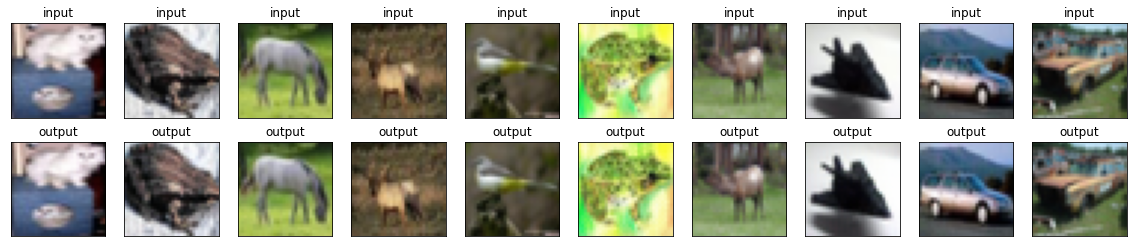

In [15]:
plot_rec(x_train)